# Reinforcement Learning with Function Approximation

In [3]:
#!pip install torch==1.2.0 torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
#!sudo apt-get install xvfb
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull origin master > /dev/null 2>&1


In [4]:
from pathlib import Path
import base64
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import math

import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output


# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

# It does not seem to work well   
#display = Display(visible=0, size=(1400, 900))
#display.start();



PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |


**Tutorials on PyTorch:** https://pytorch.org/tutorials/


## OpenAI gym
We will consider environments provided by OpenAI gym
This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

In [5]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
#env = gym.make('MountainCar-v0')
#env = gym.make('Acrobot-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True)

In [6]:
done = False
state = env.reset()
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) #reward 0 or 1
env.close()
show_video("./gym-results")

## REINFORCE

**Q1: Implement the REINFORCE algorithm**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure. You will need to code the method `optimize_model`.

In [7]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

Create the model based on the properties of the MDP you want to solve

In [8]:
#env_id = 'CartPole-v1'
env_id ='MountainCar-v0'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
    (5): Softmax(dim=0)
  )
)


We provide a base agent that you will need to extend in the next cell with your implementation of `optimize_model`.

In [9]:
class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = Model(self.env.observation_space.shape[0], self.env.action_space.n)
        self.gamma = config['gamma']
        self.monitor=config['monitor']
        
        # the optimizer used by PyTorch (Stochastic Gradient, Adagrad, Adam, etc.)
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)
    
    # Method to implement
    def _compute_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step
        
        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """

      
        raise NotImplementedError
    # Method to implement
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above

        
        
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        
        raise NotImplementedError
    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories))
            
            if (episode+1)%5 == 0:
                print(f'Episode {episode + 1}/{n_update}: rewards {round(np.mean(rewards[-1]), 2)} +/- {round(np.std(rewards[-1]), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self, render=False):
        """Evaluate the agent on a single trajectory            
        """
        torch.no_grad()
        
        if self.monitor:
            observation = self.monitor_env.reset()
        else:
            observation = self.env.reset()
        
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False
        
        while not done:
            action = self.model.select_action(observation)
            
            if self.monitor:
                observation, reward, done, info = self.monitor_env.step(int(action))
            else:
                observation, reward, done, info = self.env.step(int(action))
          
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
        
        self.monitor_env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        print(f'Reward: {reward_episode}')

Finally you can implement your agent

In [10]:
class REINFORCE(BaseAgent):
    
    def _compute_returns(self, rewards):
        
        returns=0
        for i in range(len(rewards)):
            returns=self.gamma*returns+rewards[-(i+1)]
        return(returns)
               
    def optimize_model(self, n_trajectories):
      
        reward_trajectories=[]
        list_sum_proba=[]
        
        #Here I compute n_trajectories trajectories in order to calculate the MonteCarlo estimate of the J function
        for i in range(n_trajectories):
            done = False
            rewards=[]
            
            if self.monitor:
                state=self.monitor_env.reset()
            else:
                state=self.env.reset()
            
            
            state=torch.tensor(state, dtype=torch.float)
            
            sum_lprob=0
            while not done:
                
                proba=self.model.forward(state)
                action=self.model.select_action(state)
                sum_lprob+= proba[action].log()
                
                if self.monitor:
                    state, reward, done, info =self.monitor_env.step(int(action))
                else:
                    state, reward, done, info =self.env.step(int(action))
               
                rewards.append(reward)
                
                state=torch.tensor(state, dtype=torch.float)
            
            list_sum_proba.append(sum_lprob)
            reward_trajectories.append(self._compute_returns(rewards))
        
        
        loss=0
        for i in range(len(list_sum_proba)):
            loss+=-list_sum_proba[i]*reward_trajectories[i]
        
        loss=loss/len(list_sum_proba)
       
        # The following lines take care of the gradient descent step for the variable loss
        # that you need to compute.
        
        # Discard previous gradients
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        
        return reward_trajectories
    

In [11]:
env_id = 'CartPole-v1'
#env_id = 'MountainCar-v0'
#env_id = 'Acrobot-v1'
learning_rate = 0.01
gamma = 1.0
seed = 42
monitor=False

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma,
    'monitor': monitor
}

print("Current config is:")
pprint(config)


Current config is:
{'env_id': 'CartPole-v1',
 'gamma': 1.0,
 'learning_rate': 0.01,
 'monitor': False,
 'seed': 42}


Episode 5/70: rewards 25.18 +/- 12.09
Episode 10/70: rewards 22.68 +/- 9.96
Episode 15/70: rewards 28.02 +/- 14.81
Episode 20/70: rewards 30.58 +/- 22.13
Episode 25/70: rewards 38.22 +/- 20.97
Episode 30/70: rewards 46.32 +/- 33.35
Episode 35/70: rewards 52.38 +/- 26.61
Episode 40/70: rewards 106.92 +/- 58.62
Episode 45/70: rewards 167.25 +/- 74.06
Episode 50/70: rewards 294.68 +/- 114.9
Episode 55/70: rewards 344.05 +/- 117.55
Episode 60/70: rewards 301.65 +/- 97.71
Episode 65/70: rewards 339.18 +/- 88.96
Episode 70/70: rewards 485.6 +/- 36.33


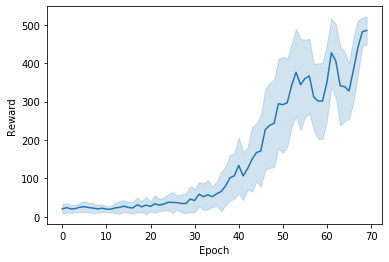

In [12]:
agent = REINFORCE(config)
agent.train(n_trajectories=40, n_update=70)

Evaluate the agent over multiple episodes

In [13]:
agent.evaluate(render=False)


Reward: 462.0


## Policy Evaluation as Supervised Learning

**Q2: Implement batched gradient algorithm**

Define network for Q-function (ValueNetwork) and policy (ActorNetwork)


In [14]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

In [15]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

Implement your (batched) gradient algorithm



In [17]:
class EvalAgent:

    def __init__(self, config, policy):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        self.policy = policy

        # Our network
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)

        # optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), 
                                                   lr=config['value_network']['learning_rate'])
    
    def _returns_advantages(self, rewards, dones, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        
        
        
        returns : array
            The cumulative discounted rewards
        """
        #Backward calculation of the sum of rewards
        sum_rewards=np.ones(len(rewards))
        cum_reward=next_value
        for i in range(len(rewards)):
            cum_reward=self.gamma*cum_reward+rewards[-(i+1)]
            sum_rewards[-(i+1)]=cum_reward
            
            #If the environment fails then we start from 0
            if dones[-(i+1)]: 
                cum_reward=0
        
        return(sum_rewards)
           
        
        
        
    def optimize_model(self, states, actions, returns): #, advantages):
        """Perform a gradient update using provided transitions

        Parameters
        ----------
        observations : array
            The observations
        actions : array
            The actions
        returns : array
            The returns from each state

        Returns
        -------
        loss_value: int
            The loss value
        """
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns, dtype=torch.float)
        states  = torch.tensor(states, dtype=torch.float)
                
        network_pred=[self.value_network(state) for state in states]
         
        self.value_network_optimizer.zero_grad()
        
        #The loss will contain the RMSE between the value from the network and the value computed as the discounted sum of rewards
        loss=0 
        
        for i in range(len(network_pred)):
            loss+=(network_pred[i]-returns[i])**2
            loss=loss/len(network_pred)
            
        loss.backward()
        
        self.value_network_optimizer.step()
        
        return loss
    
    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = torch.tensor(self.env.reset(),dtype=torch.float)
        mse_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            
            #intialization :
            observation=torch.tensor(self.env.reset(),dtype=torch.float)
            
            for i in range(batch_size):
                
                values[i] =  self.value_network.predict(observation)
                actions[i] = self.policy.select_action(observation)
                observations[i] = observation 
                
                observation, reward, done, b=self.env.step(int(actions[i]))
                observation=torch.tensor(observation,dtype=torch.float)
                
                # step
                
                dones[i]=done
                rewards[i]=reward

                if dones[i]:
                    observation = torch.tensor(self.env.reset(),dtype=torch.float)

            # If our episode didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network.predict(observation) 
                

            # Update episode_count
            episode_count += sum(dones)

            # Compute returns
            returns = self._returns_advantages(rewards, dones, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns)

            # Test it every 50 epochs
            if epoch % 25 == 0 or epoch == epochs - 1:
                L = []
                for _ in range(10):
                    obs_states, y_mc = self.evaluate()
                    y_hat = [self.value_network.predict(torch.tensor(obs,dtype=torch.float)) for obs in obs_states]# compute prediction
                    err = y_mc - y_hat
                    mse = np.mean(err**2)
                    L.append(mse.item())
                mse_test.append(L)
                print(f'Epoch {epoch}/{epochs}: MSE: {np.mean(mse)}')

                observation = self.env.reset()

        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], mse_test[i]) for i in range(len(mse_test))))), columns=['Epoch', 'MSE'])
        sns.lineplot(x="Epoch", y="MSE", data=r, ci='sd');

        print(f'The trainnig was done over a total of {episode_count} episodes')

    def evaluate(self, render=False):
        """Returns the observations and the estimated V-function (using first visit Monte-Carlo)

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        states : array
            Observations
        returns : array
            The estimate value function of each state
        """
        env = self.monitor_env if render else self.env
        observation = env.reset()
        states = [observation.copy()]
        rewards= []
        observation = torch.tensor(observation, dtype=torch.float)
        done = False
        steps = 0

        while not done:
            action = self.policy.select_action(observation)
            observation, reward, done, info = env.step(int(action))
            for i in range(steps):
                rewards[i] = rewards[i] + math.pow(self.gamma, steps-i)*reward
            rewards.append(reward)
            if not done:
                states.append(observation.copy())
            observation = torch.tensor(observation, dtype=torch.float)
            steps += 1

        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        states = np.array(states).reshape(-1, self.env.observation_space.shape[0])
        returns = np.array(rewards).reshape(-1,1)
        return states, returns

Define configuration

In [18]:
env_id = 'CartPole-v1'

value_learning_rate = 0.001
gamma = 0.99
seed = 1

config_td = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate, 'reference': './CartPole_value.pt'}
}

print("Current config_td is:")
pprint(config_td)


Current config_td is:
{'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001, 'reference': './CartPole_value.pt'}}


Create policy

In [19]:
env = gym.make(config_td['env_id'])
policy = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)
policy.load_state_dict(torch.load('./mvarl_hands_on/data/CartPole_actor.pt')) 
state = torch.tensor(np.array(env.reset(), dtype=np.float32))
print("pi(state) = ", policy.select_action(state))
del env

pi(state) =  [0]


Run agent

Epoch 0/1000: MSE: 7038.722308171475
Epoch 25/1000: MSE: 6988.897180425787
Epoch 50/1000: MSE: 6930.282807147791
Epoch 75/1000: MSE: 6842.953394354863
Epoch 100/1000: MSE: 6723.910899671744
Epoch 125/1000: MSE: 6572.673712953795
Epoch 150/1000: MSE: 5232.65591801315
Epoch 175/1000: MSE: 6145.106755734037
Epoch 200/1000: MSE: 5901.694815647452
Epoch 225/1000: MSE: 5682.06360680968
Epoch 250/1000: MSE: 5386.213794994471
Epoch 275/1000: MSE: 5056.513748786542
Epoch 300/1000: MSE: 4705.727186002372
Epoch 325/1000: MSE: 4070.287320308077
Epoch 350/1000: MSE: 4120.981948772945
Epoch 375/1000: MSE: 3770.026220167783
Epoch 400/1000: MSE: 3418.7495578205076
Epoch 425/1000: MSE: 3142.0657634483823
Epoch 450/1000: MSE: 2784.952402193586
Epoch 475/1000: MSE: 1896.877770147054
Epoch 500/1000: MSE: 2246.236565371308
Epoch 525/1000: MSE: 2133.982827386099
Epoch 550/1000: MSE: 1840.222400012482
Epoch 575/1000: MSE: 1477.9466576834752
Epoch 600/1000: MSE: 1357.6955984396827
Epoch 625/1000: MSE: 1144.54

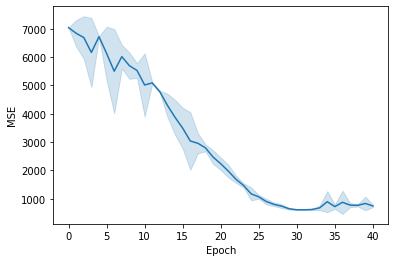

In [20]:
agent = EvalAgent(config=config_td, policy=policy)
agent.training_batch(epochs=1000, batch_size=256)


## Advantage Actor Critic (A2C)
**Q3: Implement the A2C method**

As usual we provide a structure you can use as starting point.



**Note:** try to reuse previous parts of previous code.



In [25]:
class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
        
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
  
        sum_rewards=torch.tensor(np.ones(len(rewards)),dtype=torch.float)
        cum_reward=next_value
        for i in range(len(rewards)):
            cum_reward=self.gamma*cum_reward+rewards[-(i+1)]
            sum_rewards[-(i+1)]=cum_reward
            
            if dones[-(i+1)]:
                cum_reward=0
        
        advantages=[sum_rewards[i]-values[i] for i in range(len(sum_rewards))]
        
        return(sum_rewards,advantages)
           
        

    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards,values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        rewards_test = []
       
        for epoch in range(epochs):
            
            observation = torch.tensor(self.env.reset(),dtype=torch.float)
            
            for i in range(batch_size):
            # Lets collect one batch
                
                actions[i] = self.actor_network.select_action(observation)
                observations[i] = observation 
                
                # step
                observation, reward, done, b=self.env.step(int(actions[i]))
                observation=torch.tensor(observation,dtype=torch.float)
                
                dones[i]=done
                rewards[i]=reward

                if dones[i]:
                    observation = torch.tensor(self.env.reset(),dtype=torch.float)

            # If our episode didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                    next_value = 0
            else:
                    next_value = self.value_network.predict(observation) 

            values=[self.value_network(torch.tensor(observation,dtype=torch.float)) for observation in observations]
            probs=[self.actor_network(torch.tensor(observation,dtype=torch.float)) for observation in observations]

            # Update episode_count
            episode_count += sum(dones)

            # Compute returns and advantages
            returns, advantages = self._returns_advantages(rewards, dones, values, next_value)
           
            # Learning step !
            self.optimize_model(observations, actions, returns, advantages, probs)
            
            
            
        # Test it every 50 epochs
            if epoch % 50 == 0 or epoch == epochs - 1:
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

                # Early stopping
                if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                    print('Early stopping !')
                    break
                observation = self.env.reset()
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
        print(f'The trainnig was done over a total of {episode_count} episodes')

    def optimize_model(self, observations, actions, returns, advantages, probs):
        
        probs=[probs[i][int(actions[i])] for i in range(len(actions))]
        advantages=[float(advantages[i].detach()) for i in range(len(advantages))]
        
        # MSE for the values
        # Actor & Entropy loss
        #value network
        loss_value=0
        
        for i in range(len(advantages)):
            loss_value+=advantages[i]**2
        
        #prob network
        loss_prob=0
        
        for i in range(len(probs)):
            loss_prob-=probs[i].log()*advantages[i]                      
        
        #entropy 
        loss_entropy=0
        
        for i in range(len(probs)):
            loss_entropy += -probs[i]*probs[i].log()
        
        loss_tot=loss_value+loss_prob+0.0001*loss_entropy
        
        self.value_network_optimizer.zero_grad()
        self.actor_network_optimizer.zero_grad()
        
        loss_tot.backward()
        
        self.value_network_optimizer.step()
        self.actor_network_optimizer.step()
        
     
        
        return(loss_tot)

    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            observation, reward, done, info = env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

Create configuration for A2C

In [26]:
env_id = 'CartPole-v1'
#env_id = 'MountainCar-v0'
value_learning_rate = 0.001
actor_learning_rate = 0.001
gamma = 0.99
entropy = 1
seed = 1

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
pprint(config_a2c)

Current config_a2c is:
{'actor_network': {'learning_rate': 0.001},
 'entropy': 1,
 'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001}}


Run the learning agent

Epoch 0/1000: Mean rewards: 19.86, Std: 9.84
Epoch 50/1000: Mean rewards: 32.24, Std: 13.49
Epoch 100/1000: Mean rewards: 44.42, Std: 21.69
Epoch 150/1000: Mean rewards: 57.9, Std: 30.99
Epoch 200/1000: Mean rewards: 70.74, Std: 35.48
Epoch 250/1000: Mean rewards: 132.38, Std: 55.31
Epoch 300/1000: Mean rewards: 158.36, Std: 62.91
Epoch 350/1000: Mean rewards: 144.8, Std: 53.6
Epoch 400/1000: Mean rewards: 187.28, Std: 67.3
Epoch 450/1000: Mean rewards: 241.8, Std: 95.17
Epoch 500/1000: Mean rewards: 212.38, Std: 68.64
Epoch 550/1000: Mean rewards: 217.32, Std: 90.85
Epoch 600/1000: Mean rewards: 230.1, Std: 82.74
Epoch 650/1000: Mean rewards: 281.22, Std: 108.06
Epoch 700/1000: Mean rewards: 358.5, Std: 113.79
Epoch 750/1000: Mean rewards: 349.38, Std: 107.9
Epoch 800/1000: Mean rewards: 392.8, Std: 112.03
Epoch 850/1000: Mean rewards: 349.68, Std: 137.48
Epoch 900/1000: Mean rewards: 248.9, Std: 85.82
Epoch 950/1000: Mean rewards: 342.98, Std: 135.05
Epoch 999/1000: Mean rewards: 329

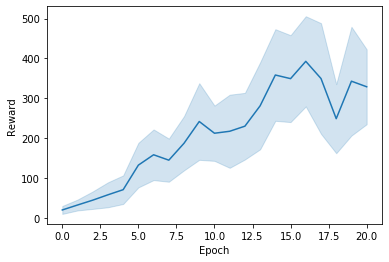

In [27]:
agent = A2CAgent(config_a2c)
rewards = agent.training_batch(1000, 256)

Evaluate the agent over multiple episodes

In [0]:
agent.evaluate()

It doesn't seem to learn anything 
,with the other environments